In [1]:
#Data cleanup here

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import csv
import json
import requests
import seaborn as sns
import time

In [2]:
# Pull csv using URL of dataset uploaded to repo

url = 'https://raw.githubusercontent.com/calderon0423/Commitment-Issues/master/Dataset/'

all_homes = pd.read_csv(f'{url}State_MedianRentalPrice_AllHomes.csv')
del all_homes['Unnamed: 0']
all_homes.head()

,RegionName,SizeRank,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,...,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12
0,California,1,NaN,NaN,2400.0,2400.0,2400.0,2495.0,2500.0,2595.0,...,2750.0,2800,2800.0,2800.0,2800.0,2850,2800.0,2800.0,2800.0,2800.0
1,Texas,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1550.0,1575,1595.0,1595.0,1600.0,1595,1590.0,1550.0,1550.0,1550.0
2,New York,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3200.0,3495,3299.0,3295.0,3200.0,3395,3250.0,2950.0,3000.0,3200.0
3,Florida,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1850.0,1850,1850.0,1845.0,1800.0,1800,1800.0,1800.0,1795.0,1790.0
4,Illinois,5,1575.0,1500.0,1500.0,1500.0,1500.0,1500.0,1550.0,1520.0,...,1600.0,1600,1600.0,1642.5,1647.0,1650,1625.0,1600.0,1595.0,1590.0


In [4]:
# Convert the data to long form
all_homes_long = pd.melt(all_homes, id_vars=['RegionName', 'SizeRank'])

#Rename columns
all_homes_long.columns = ['RegionName', 'SizeRank', 'Time', 'Value']

#Filter for years 2016 and 2017
all_homes_long = all_homes_long.loc[all_homes_long['Time'].isin(['2016-01', '2016-02', '2016-03', '2016-04', 
                                                                 '2016-05', '2016-06', '2016-07', '2016-08', 
                                                                 '2016-09', '2016-10', '2016-11', '2016-12',
                                                                 '2017-01', '2017-02', '2017-03', '2017-04', 
                                                                 '2017-05', '2017-06', '2017-07', '2017-08', 
                                                                 '2017-09', '2017-10', '2017-11', '2017-12'])]

#Drop NAs after filtering so NAs in previous years don't affect
all_homes_long = all_homes_long.dropna()

#View counts for each state to exclude states with less than 24 months of data
all_homes_long.RegionName.value_counts()


Kentucky                24
Arkansas                24
South Carolina          24
New Hampshire           24
Tennessee               24
Kansas                  24
District of Columbia    24
Ohio                    24
Delaware                24
Oregon                  24
New Jersey              24
New Mexico              24
Idaho                   24
Mississippi             24
Washington              24
North Dakota            24
Alabama                 24
Michigan                24
Oklahoma                24
Pennsylvania            24
Minnesota               24
Wyoming                 24
New York                24
Texas                   24
South Dakota            24
Illinois                24
North Carolina          24
Connecticut             24
Maryland                24
Florida                 24
Massachusetts           24
Virginia                24
Colorado                24
Georgia                 24
Maine                   24
Rhode Island            24
California              24
I

In [5]:
#Exclude Nebraska and Puerto Rico as they have less than 24 months of data
all_homes_long = all_homes_long.loc[~all_homes_long.RegionName.isin(['Puerto Rico', 'Nebraska'])]

all_homes_long

,RegionName,SizeRank,Time,Value
3672,California,1,2016-01,2300.0
3673,Texas,2,2016-01,1400.0
3674,New York,3,2016-01,3200.0
3675,Florida,4,2016-01,1700.0
3676,Illinois,5,2016-01,1550.0
...,...,...,...,...
4890,South Dakota,46,2017-12,1097.5
4891,Alaska,47,2017-12,1595.0
4892,North Dakota,48,2017-12,1170.0
4893,District of Columbia,49,2017-12,2595.0


In [6]:
#Convert Time to proper date-time
all_homes_long['Time'] = pd.to_datetime(all_homes_long['Time']) 
all_homes_long['Year'] = pd.DatetimeIndex(all_homes_long['Time']).year
all_homes_long['Month'] = pd.DatetimeIndex(all_homes_long['Time']).month
all_homes_long

,RegionName,SizeRank,Time,Value,Year,Month
3672,California,1,2016-01-01,2300.0,2016,1
3673,Texas,2,2016-01-01,1400.0,2016,1
3674,New York,3,2016-01-01,3200.0,2016,1
3675,Florida,4,2016-01-01,1700.0,2016,1
3676,Illinois,5,2016-01-01,1550.0,2016,1
...,...,...,...,...,...,...
4890,South Dakota,46,2017-12-01,1097.5,2017,12
4891,Alaska,47,2017-12-01,1595.0,2017,12
4892,North Dakota,48,2017-12-01,1170.0,2017,12
4893,District of Columbia,49,2017-12-01,2595.0,2017,12


<IPython.core.display.Javascript object>


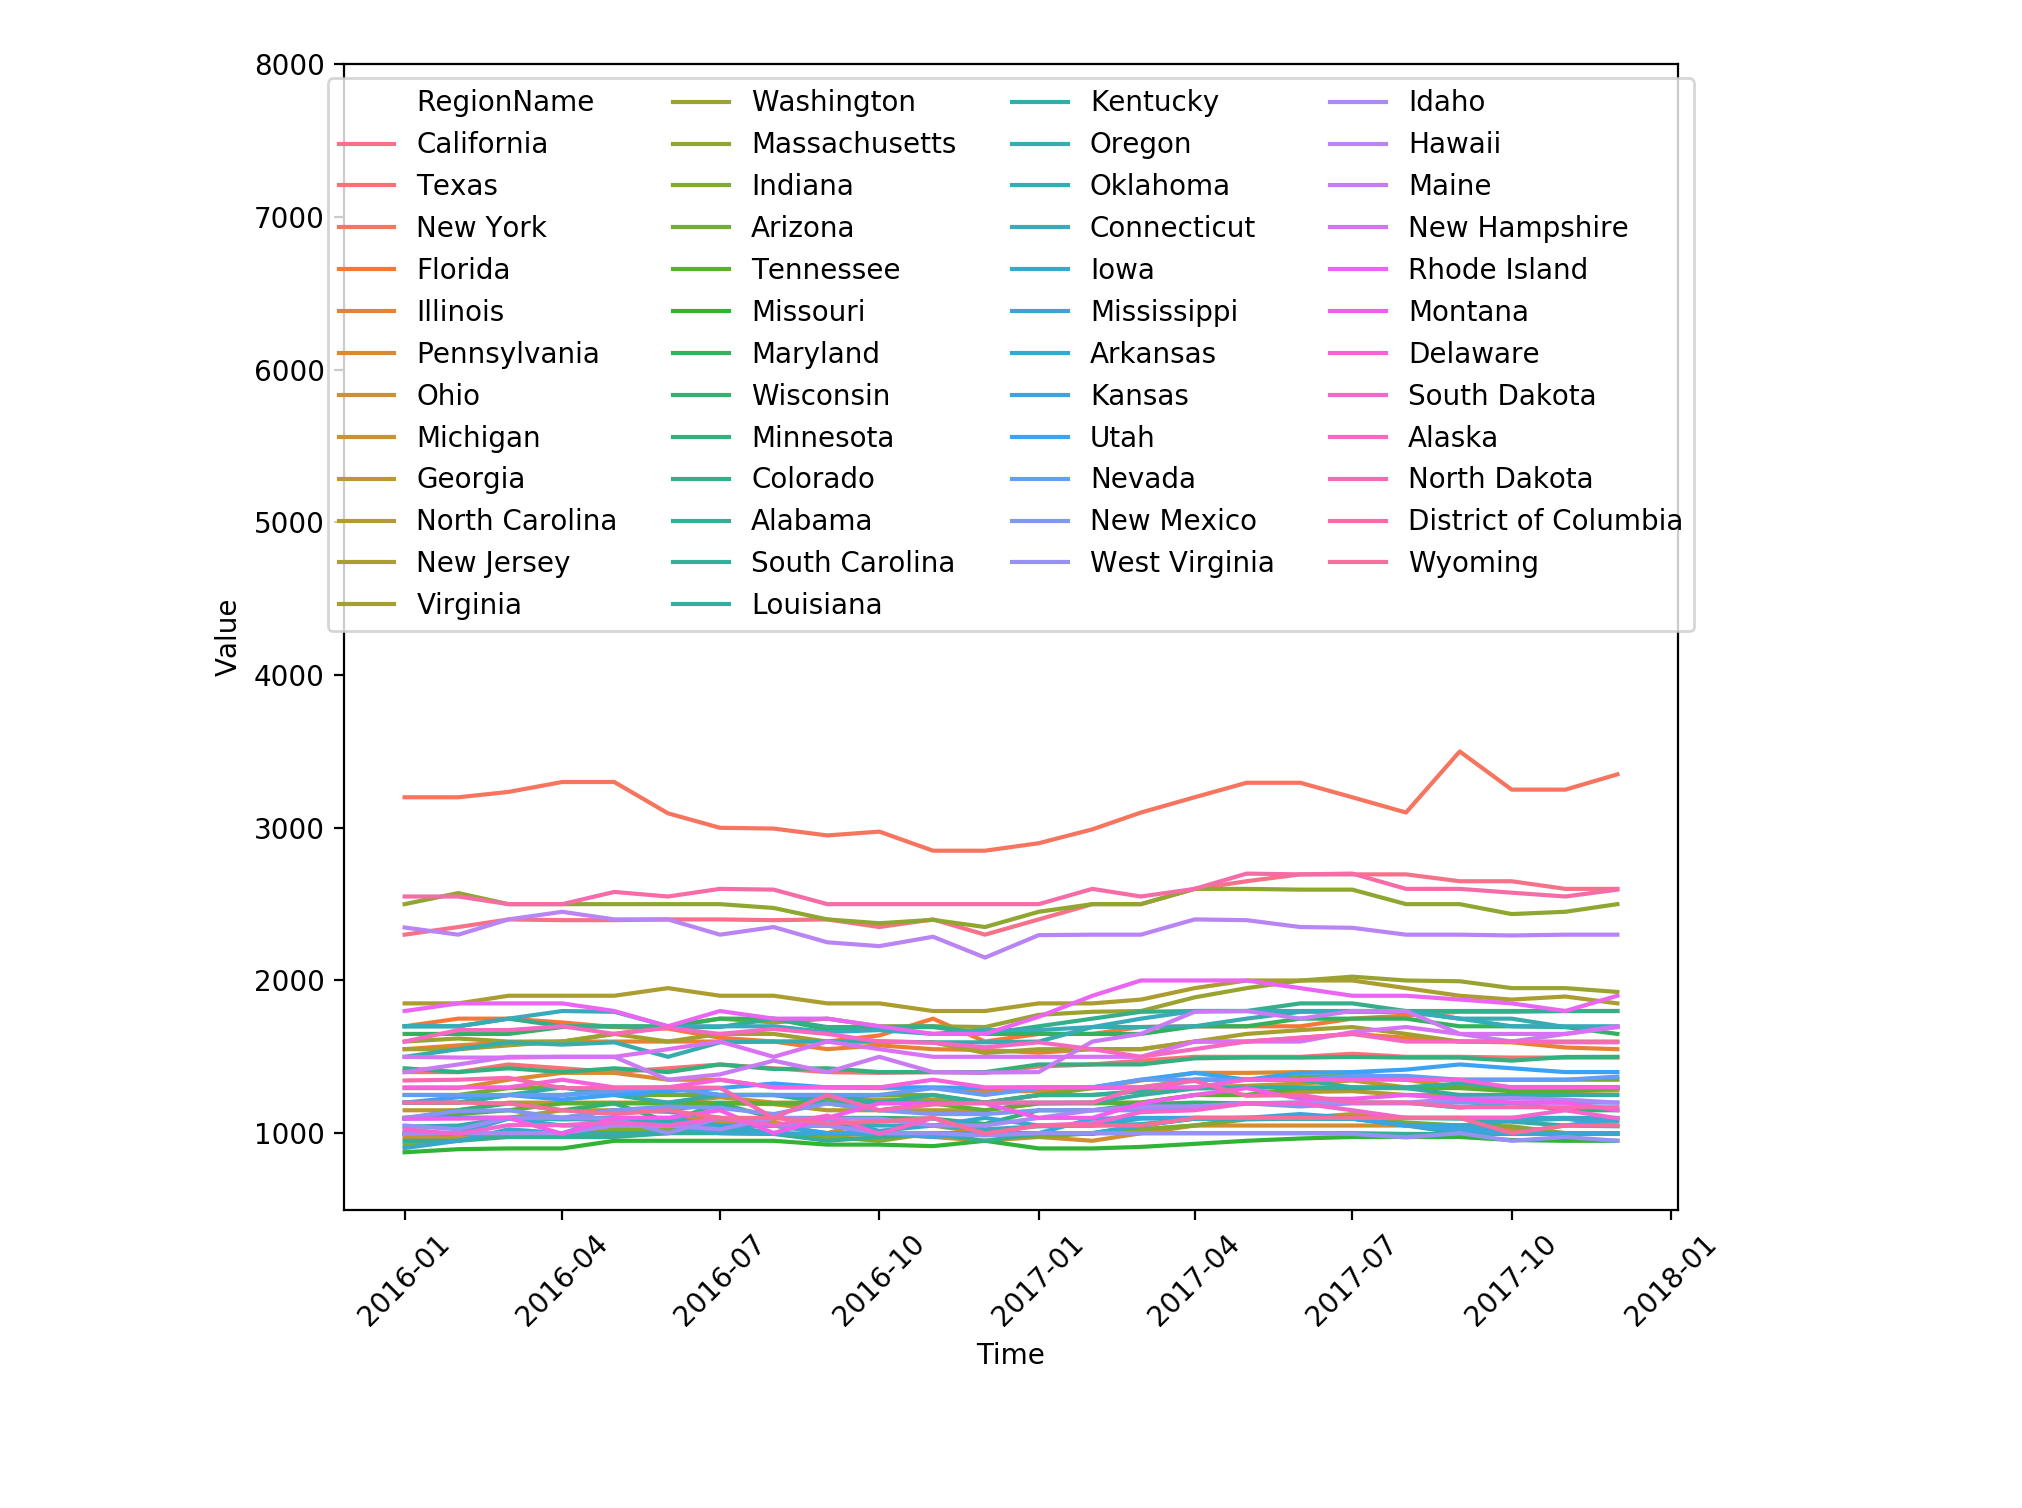

In [20]:
%matplotlib notebook

#Plot the change in rent from Jan 2016 to Dec 2017 for each state
sns.lineplot(x="Time", y="Value", data=all_homes_long, hue='RegionName', legend='full')
plt.xticks(rotation=45)

# Move the legend to an empty part of the plot
plt.legend(loc='upper center', ncol=4)
plt.ylim(500, 8000)
plt.show()
plt.tight_layout()

In [7]:
#Create datasets 
merged_df_2016 = all_homes_long.loc[(all_homes_long['Time'] >= '2016-01-01') & (all_homes_long['Time'] <= '2016-12-01')]

merged_df_2017 = all_homes_long.loc[(all_homes_long['Time'] >= '2017-01-01') & (all_homes_long['Time'] <= '2017-12-01')]

all_homes_long.to_csv('all_homes_long.csv')

,RegionName,SizeRank,Time,Value,Year,Month
3672,California,1,2016-01-01,2300.0,2016,1
3673,Texas,2,2016-01-01,1400.0,2016,1
3674,New York,3,2016-01-01,3200.0,2016,1
3675,Florida,4,2016-01-01,1700.0,2016,1
3676,Illinois,5,2016-01-01,1550.0,2016,1
...,...,...,...,...,...,...
4278,South Dakota,46,2016-12-01,995.0,2016,12
4279,Alaska,47,2016-12-01,1562.5,2016,12
4280,North Dakota,48,2016-12-01,1200.0,2016,12
4281,District of Columbia,49,2016-12-01,2500.0,2016,12


In [ ]:
#Enter any hubs we want to filter by
#hubs = ['New York-Newark-Jersey City', 'San Francisco-Oakland-Hayward', 'Seattle', 'Atlanta']

